<a href="https://colab.research.google.com/github/asatbayev/Capstone-Project/blob/main/Best_Chinese_Restaurant_Location_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Best location to open new Chinese Restaurant in Toronto.**

## **1. Introduction/Business Problem.**

Owner of the global chain of Chinese restaurants wants to open brand new restaurant in Toronto as a part of the strategic development plan in North America.

A restaurant's location is one the most important factors for its success. So, it is critical to find the best location.

He requested our firm to propose the best Toronto neighborhood to establish a Chinese restaurant.

## **2. Data acquisition and cleaning.**

### **2.1. Data sources.**

Following data will be used for analysis:
1. The Toronto's crime rates data. (https://open.toronto.ca/dataset/neighbourhood-crime-rates/)
2. Geographical coordinates of each neighbourhood: (https://www.openstreetmap.org).
3. The Foursquare API will be used to explore neighborhood venues in Toronto. We will check presence of Chinese restaurants in each neighborhood to check possible competition.
4. The Toronto's census data for its social demographic characteristics (https://bit.ly/3airrOJ). We will obtain spending power, total population and distribution of Chinese population.

### **2.2 Data cleaning.**

**Install all necessary modules and import necessary libraries.**

In [ ]:
!pip install geopy
!pip install geocoder
!pip install geopandas
!pip install chart_studio
!pip install datapane

In [ ]:
import numpy as np  # library to handle data in a vectorized manner

import pandas as pd  # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

import requests  # library to handle requests
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

import geocoder  # import geocoder
import plotly.express as px
import geopandas as gpd # to strore geospatial data
import chart_studio
import chart_studio.plotly as py # for exporting Plotly visualizations to Chart Studio
import plotly.graph_objects as go # to ploty Plotly graph objects
import plotly.io as pio # Plotly renderer
import matplotlib.pyplot as plt # Import Matplotlib for visualizations
import datapane as dp # for exporting map visualizations to Datapane
from plotly.subplots import make_subplots # to make multiple Plotly plots in one instance

import plotly.offline as pyo # Set notebook mode to work in offline
pyo.init_notebook_mode()

print('Libraries imported.')

Libraries imported.


**Import data from census CSV file into dataframe.
Check dataframe's shape and statistical information.**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving wellbeing_toronto.csv to wellbeing_toronto.csv


In [ ]:
# load total population, income after tax and chinese population info of each Toronto neighbourhood
import io
df_census = pd.read_csv(io.BytesIO(uploaded['wellbeing_toronto.csv']))
print(df_census.describe())
print(df_census.shape)
print(df_census.dtypes)
df_census.head(10)

       Neighbourhood Id  Combined Indicators  After-Tax Household Income  \
count            140.00                 0.00                      140.00   
mean              70.50                  nan                   55,426.50   
std               40.56                  nan                   16,118.16   
min                1.00                  nan                   30,794.00   
25%               35.75                  nan                   46,689.50   
50%               70.50                  nan                   52,660.00   
75%              105.25                  nan                   59,963.00   
max              140.00                  nan                  161,448.00   

       Total Population     Chinese  
count            140.00      140.00  
mean          19,511.22    2,139.18  
std           10,033.59    3,526.50  
min            6,577.00      100.00  
25%           12,019.50      448.75  
50%           16,749.50      840.00  
75%           23,854.50    1,955.00  
max        

Neighbourhood  Neighbourhood Id  Combined Indicators  \
0             West Humber-Clairville              1.00                  nan   
1  Mount Olive-Silverstone-Jamestown              2.00                  nan   
2       Thistletown-Beaumond Heights              3.00                  nan   
3                    Rexdale-Kipling              4.00                  nan   
4                   Elms-Old Rexdale              5.00                  nan   
5      Kingsview Village-The Westway              6.00                  nan   
6   Willowridge-Martingrove-Richview              7.00                  nan   
7           Humber Heights-Westmount              8.00                  nan   
8           Edenbridge-Humber Valley              9.00                  nan   
9                 Princess-Rosethorn             10.00                  nan   

   After-Tax Household Income  Total Population     Chinese  
0                   59,703.00         33,312.00      470.00  
1                   46,986.00         32,954.00      285.00  
2                   57,522.00         10,360.00      110.00  
3                   51,194.00         10,529.00      165.00  
4                   49,425.00          9,456.00      105.00  
5                   50,714.00         22,000.00      410.00  
6                   57,048.00         22,156.00      515.00  
7                   54,919.00         10,948.00      100.00  
8                   62,463.00         15,535.00      370.00  
9                   93,391.00         11,051.00      500.00

**I decided to limit neghbourhoods for analysis and took only those which had  total and Chinese population more than mean values (20 000 and 2 000 respectively).**

In [ ]:
df_census.drop(['Combined Indicators'], axis=1, inplace=True)
df_census = df_census.rename(columns={'   Chinese':'Chinese Population', 'After-Tax Household Income':'Household Income'})
df_census = df_census.loc[(df_census['Chinese Population'] >= 2000) & (df_census['Total Population'] >= 20000)]
df_census = df_census.reset_index(drop=True)
print(df_census.shape)
df_census

(25, 5)


Neighbourhood  Neighbourhood Id  Household Income  \
0                    Newtonbrook West             36.00         46,815.00   
1                   Banbury-Don Mills             42.00         60,203.00   
2                   Parkwoods-Donalda             45.00         52,550.00   
3                  Don Valley Village             47.00         51,247.00   
4                     Willowdale East             51.00         55,154.00   
5                     Bayview Village             52.00         58,028.00   
6                     South Riverdale             70.00         56,192.00   
7               Church-Yonge Corridor             75.00         41,813.00   
8                 Bay Street Corridor             76.00         44,614.00   
9   Waterfront Communities-The Island             77.00         57,670.00   
10                            Niagara             82.00         59,929.00   
11  Dovercourt-Wallace Emerson-Juncti             93.00         50,741.00   
12                              Annex             95.00         49,912.00   
13                            Steeles            116.00         55,755.00   
14                         L'Amoreaux            117.00         49,769.00   
15             Tam O'Shanter-Sullivan            118.00         46,095.00   
16                Clairlea-Birchmount            120.00         53,716.00   
17                        Dorset Park            126.00         47,630.00   
18                            Bendale            127.00         51,254.00   
19       Agincourt South-Malvern West            128.00         53,886.00   
20                    Agincourt North            129.00         55,893.00   
21                           Milliken            130.00         55,464.00   
22                              Rouge            131.00         72,784.00   
23                            Malvern            132.00         53,425.00   
24                             Woburn            137.00         47,908.00   

    Total Population  Chinese Population  
0          23,831.00            2,650.00  
1          27,695.00            4,630.00  
2          34,805.00            2,875.00  
3          27,051.00            6,960.00  
4          50,434.00           16,980.00  
5          21,396.00            5,860.00  
6          27,876.00            5,800.00  
7          31,340.00            3,835.00  
8          25,797.00            7,435.00  
9          65,913.00            9,020.00  
10         31,180.00            2,260.00  
11         36,625.00            2,825.00  
12         30,526.00            2,145.00  
13         24,623.00           17,755.00  
14         43,993.00           16,165.00  
15         27,446.00            8,665.00  
16         26,984.00            2,120.00  
17         25,003.00            2,745.00  
18         29,960.00            4,400.00  
19         23,757.00           11,110.00  
20         29,113.00           16,460.00  
21         26,572.00           18,715.00  
22         46,496.00            2,100.00  
23         43,794.00            3,275.00  
24         53,485.00            3,715.00

**Import data from crime rate CSV file into dataframe.
Check dataframe's shape**.

In [ ]:
uploaded = files.upload()

Saving neighbourhood-crime-rates.csv to neighbourhood-crime-rates.csv


In [ ]:
import io
df_crime = pd.read_csv(io.BytesIO(uploaded['neighbourhood-crime-rates.csv']))

In [ ]:
print(df_crime.shape)
print(df_crime.dtypes)
df_crime.head()

**Create 'TotalCrimeRate2020' column to summarize all crime type rates for 2020 and remove all the rest columns.**

In [ ]:
df_crime = df_crime[['Neighbourhood', 'Hood_ID', 'Assault_Rate2020', 'AutoTheft_Rate2020', 'BreakAndEnter_Rate2020', 'Robbery_Rate2020', 'TheftOver_Rate2020', 'Homicide_Rate2020', 'Shootings_Rate2020']]
df_crime['TotalCrimeRate2020'] = df_crime['Assault_Rate2020'] + df_crime['BreakAndEnter_Rate2020'] + df_crime['Assault_Rate2020'] + df_crime['Robbery_Rate2020'] + df_crime['TheftOver_Rate2020'] + df_crime['Homicide_Rate2020'] + df_crime['Shootings_Rate2020']
df_crime = df_crime[['Neighbourhood', 'Hood_ID', 'TotalCrimeRate2020']]
print(df_crime.shape)
df_crime.head()

(140, 3)


Neighbourhood  Hood_ID  TotalCrimeRate2020
0           Yonge-St.Clair       97              568.06
1  York University Heights       27            2,939.52
2         Lansing-Westgate       38            1,399.76
3       Yorkdale-Glen Park       31            2,653.76
4      Stonegate-Queensway       16              977.75

**Merge crime dataframe with census dataframe based on Neighbourhood ID.**

In [ ]:
df_hoods = pd.merge(df_census, df_crime, left_on='Neighbourhood Id', right_on='Hood_ID', how='left')
df_hoods = df_hoods[['Neighbourhood_y', 'Household Income', 'Total Population', 'Chinese Population', 'TotalCrimeRate2020']]
df_hoods = df_hoods.rename(columns = {'Neighbourhood_y': 'Neighbourhood Name'})
df_hoods

Neighbourhood Name  Household Income  Total Population  \
0                      Newtonbrook West         46,815.00         23,831.00   
1                     Banbury-Don Mills         60,203.00         27,695.00   
2                     Parkwoods-Donalda         52,550.00         34,805.00   
3                    Don Valley Village         51,247.00         27,051.00   
4                       Willowdale East         55,154.00         50,434.00   
5                       Bayview Village         58,028.00         21,396.00   
6                       South Riverdale         56,192.00         27,876.00   
7                 Church-Yonge Corridor         41,813.00         31,340.00   
8                   Bay Street Corridor         44,614.00         25,797.00   
9     Waterfront Communities-The Island         57,670.00         65,913.00   
10                              Niagara         59,929.00         31,180.00   
11  Dovercourt-Wallace Emerson-Junction         50,741.00         36,625.00   
12                                Annex         49,912.00         30,526.00   
13                              Steeles         55,755.00         24,623.00   
14                           L'Amoreaux         49,769.00         43,993.00   
15               Tam O'Shanter-Sullivan         46,095.00         27,446.00   
16                  Clairlea-Birchmount         53,716.00         26,984.00   
17                          Dorset Park         47,630.00         25,003.00   
18                              Bendale         51,254.00         29,960.00   
19         Agincourt South-Malvern West         53,886.00         23,757.00   
20                      Agincourt North         55,893.00         29,113.00   
21                             Milliken         55,464.00         26,572.00   
22                                Rouge         72,784.00         46,496.00   
23                              Malvern         53,425.00         43,794.00   
24                               Woburn         47,908.00         53,485.00   

    Chinese Population  TotalCrimeRate2020  
0             2,650.00            1,654.22  
1             4,630.00              718.27  
2             2,875.00              956.69  
3             6,960.00              860.37  
4            16,980.00              712.11  
5             5,860.00              806.48  
6             5,800.00            2,077.75  
7             3,835.00            4,956.85  
8             7,435.00            4,239.10  
9             9,020.00            2,295.92  
10            2,260.00            1,318.18  
11            2,825.00            1,791.60  
12            2,145.00            2,393.31  
13           17,755.00              438.48  
14           16,165.00              987.24  
15            8,665.00            1,131.13  
16            2,120.00            1,593.75  
17            2,745.00            1,349.30  
18            4,400.00            1,531.89  
19           11,110.00            1,368.31  
20           16,460.00              566.13  
21           18,715.00              956.59  
22            2,100.00              773.77  
23            3,275.00            1,120.97  
24            3,715.00            1,457.61

**We decided to change five Neighbourhood Names to be able to obtain their coordinates through www.openstreetmap.org.**

In [ ]:
df_hoods.loc[df_hoods['Neighbourhood Name'] == 'Waterfront Communities-The Island', 'Neighbourhood Name'] = 'Toronto Islands'
df_hoods.loc[df_hoods['Neighbourhood Name'] == 'Dovercourt-Wallace Emerson-Junction', 'Neighbourhood Name'] = 'Dovercourt'
df_hoods.loc[df_hoods['Neighbourhood Name'] == 'Parkwoods-Donalda', 'Neighbourhood Name'] = 'Parkway East'
df_hoods.loc[df_hoods['Neighbourhood Name'] == 'Banbury-Don Mills', 'Neighbourhood Name'] = 'Don Mills'
df_hoods.loc[df_hoods['Neighbourhood Name'] == 'Clairlea-Birchmount', 'Neighbourhood Name'] = 'Clairlea'
df_hoods

Neighbourhood Name  Household Income  Total Population  \
0               Newtonbrook West         46,815.00         23,831.00   
1                      Don Mills         60,203.00         27,695.00   
2                   Parkway East         52,550.00         34,805.00   
3             Don Valley Village         51,247.00         27,051.00   
4                Willowdale East         55,154.00         50,434.00   
5                Bayview Village         58,028.00         21,396.00   
6                South Riverdale         56,192.00         27,876.00   
7          Church-Yonge Corridor         41,813.00         31,340.00   
8            Bay Street Corridor         44,614.00         25,797.00   
9                Toronto Islands         57,670.00         65,913.00   
10                       Niagara         59,929.00         31,180.00   
11                    Dovercourt         50,741.00         36,625.00   
12                         Annex         49,912.00         30,526.00   
13                       Steeles         55,755.00         24,623.00   
14                    L'Amoreaux         49,769.00         43,993.00   
15        Tam O'Shanter-Sullivan         46,095.00         27,446.00   
16                      Clairlea         53,716.00         26,984.00   
17                   Dorset Park         47,630.00         25,003.00   
18                       Bendale         51,254.00         29,960.00   
19  Agincourt South-Malvern West         53,886.00         23,757.00   
20               Agincourt North         55,893.00         29,113.00   
21                      Milliken         55,464.00         26,572.00   
22                         Rouge         72,784.00         46,496.00   
23                       Malvern         53,425.00         43,794.00   
24                        Woburn         47,908.00         53,485.00   

    Chinese Population  TotalCrimeRate2020  
0             2,650.00            1,654.22  
1             4,630.00              718.27  
2             2,875.00              956.69  
3             6,960.00              860.37  
4            16,980.00              712.11  
5             5,860.00              806.48  
6             5,800.00            2,077.75  
7             3,835.00            4,956.85  
8             7,435.00            4,239.10  
9             9,020.00            2,295.92  
10            2,260.00            1,318.18  
11            2,825.00            1,791.60  
12            2,145.00            2,393.31  
13           17,755.00              438.48  
14           16,165.00              987.24  
15            8,665.00            1,131.13  
16            2,120.00            1,593.75  
17            2,745.00            1,349.30  
18            4,400.00            1,531.89  
19           11,110.00            1,368.31  
20           16,460.00              566.13  
21           18,715.00              956.59  
22            2,100.00              773.77  
23            3,275.00            1,120.97  
24            3,715.00            1,457.61

**Import geospatial data for selected Toronto neighbourhoods and adding it to census/crime rate data.**

In [ ]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent='myGeocoder')
# conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# addding Toronto, Ontario, Canada to neighbourhood name to make the search more precise
df_hoods['address'] = df_hoods['Neighbourhood Name'] + ',Toronto,Ontario,Canada'
# create location column
df_hoods['location'] = df_hoods['address'].apply(geocode)
# create longitude, laatitude and altitude from location column (returns tuple)
df_hoods['point'] = df_hoods['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# split point column into latitude, longitude and altitude columns
df_hoods[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_hoods['point'].tolist(), index=df_hoods.index)

In [ ]:
# drop unnecessary columns
df_hoods = df_hoods.drop(columns=['location', 'address', 'point', 'altitude'])
df_hoods = df_hoods.reset_index(drop=True)
print(df_hoods.shape)
df_hoods

(25, 7)


Neighbourhood Name  Household Income  Total Population  \
0               Newtonbrook West         46,815.00         23,831.00   
1                      Don Mills         60,203.00         27,695.00   
2                   Parkway East         52,550.00         34,805.00   
3             Don Valley Village         51,247.00         27,051.00   
4                Willowdale East         55,154.00         50,434.00   
5                Bayview Village         58,028.00         21,396.00   
6                South Riverdale         56,192.00         27,876.00   
7          Church-Yonge Corridor         41,813.00         31,340.00   
8            Bay Street Corridor         44,614.00         25,797.00   
9                Toronto Islands         57,670.00         65,913.00   
10                       Niagara         59,929.00         31,180.00   
11                    Dovercourt         50,741.00         36,625.00   
12                         Annex         49,912.00         30,526.00   
13                       Steeles         55,755.00         24,623.00   
14                    L'Amoreaux         49,769.00         43,993.00   
15        Tam O'Shanter-Sullivan         46,095.00         27,446.00   
16                      Clairlea         53,716.00         26,984.00   
17                   Dorset Park         47,630.00         25,003.00   
18                       Bendale         51,254.00         29,960.00   
19  Agincourt South-Malvern West         53,886.00         23,757.00   
20               Agincourt North         55,893.00         29,113.00   
21                      Milliken         55,464.00         26,572.00   
22                         Rouge         72,784.00         46,496.00   
23                       Malvern         53,425.00         43,794.00   
24                        Woburn         47,908.00         53,485.00   

    Chinese Population  TotalCrimeRate2020  latitude  longitude  
0             2,650.00            1,654.22     43.80     -79.41  
1             4,630.00              718.27     43.78     -79.35  
2             2,875.00              956.69     43.76     -79.33  
3             6,960.00              860.37     43.79     -79.35  
4            16,980.00              712.11     43.76     -79.41  
5             5,860.00              806.48     43.77     -79.38  
6             5,800.00            2,077.75     43.66     -79.34  
7             3,835.00            4,956.85     43.67     -79.39  
8             7,435.00            4,239.10     43.67     -79.39  
9             9,020.00            2,295.92     43.62     -79.39  
10            2,260.00            1,318.18     43.64     -79.41  
11            2,825.00            1,791.60     43.67     -79.43  
12            2,145.00            2,393.31     43.67     -79.41  
13           17,755.00              438.48     43.82     -79.31  
14           16,165.00              987.24     43.80     -79.31  
15            8,665.00            1,131.13     43.78     -79.30  
16            2,120.00            1,593.75     43.71     -79.30  
17            2,745.00            1,349.30     43.75     -79.28  
18            4,400.00            1,531.89     43.75     -79.26  
19           11,110.00            1,368.31     43.78     -79.26  
20           16,460.00              566.13     43.81     -79.27  
21           18,715.00              956.59     43.82     -79.30  
22            2,100.00              773.77     43.80     -79.17  
23            3,275.00            1,120.97     43.81     -79.22  
24            3,715.00            1,457.61     43.76     -79.23

### **3. Exploratory Data Analysis**

**Create a Folium map**

In [ ]:
# get location of Toronto using geopy
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [ ]:
# Folium mapping
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df_hoods['latitude'], df_hoods['longitude'], df_hoods['Neighbourhood Name']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

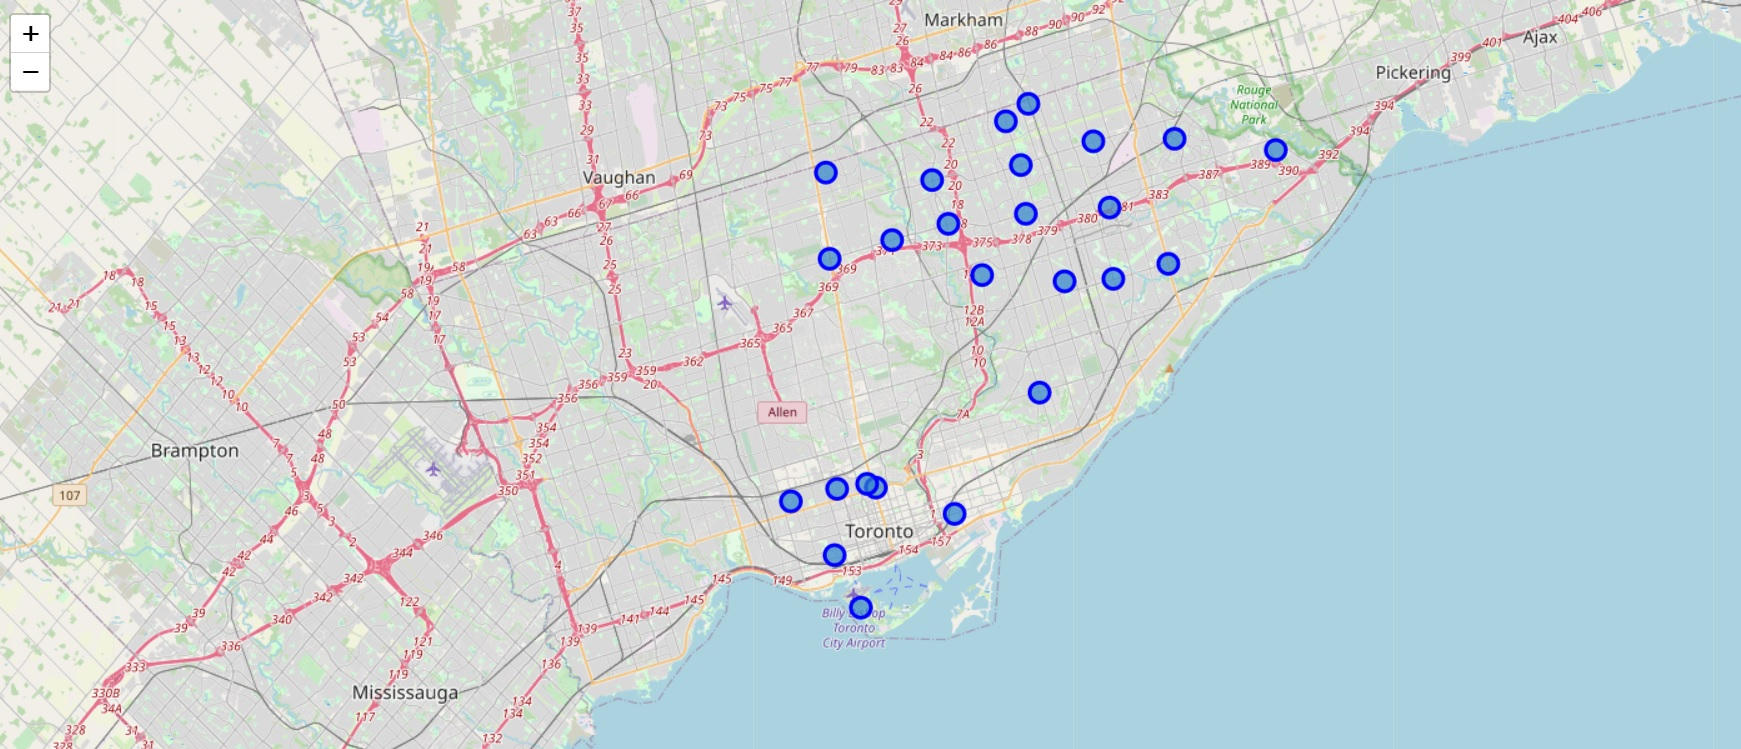

**Explore the neighbourhood using the Foursquare API**

**---DELETED Foursquare API CREDENTIALS---**

**Get the top 100 venues that are in Toronto within a radius of 1500 meters**

In [ ]:
import requests
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

def getNearbyVenues(names, latitudes, longitudes, radius=1500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)

In [ ]:
# run the function above to each neighborhood and create a new dataframe called toronto_venues
toronto_venues = getNearbyVenues(names=df_hoods['Neighbourhood Name'],
                                 latitudes=df_hoods['latitude'],
                                 longitudes=df_hoods['longitude'])

toronto_venues.head()

Newtonbrook West
Don Mills
Parkway East
Don Valley Village
Willowdale East
Bayview Village
South Riverdale
Church-Yonge Corridor
Bay Street Corridor
Toronto Islands
Niagara
Dovercourt
Annex
Steeles
L'Amoreaux
Tam O'Shanter-Sullivan
Clairlea
Dorset Park
Bendale
Agincourt South-Malvern West
Agincourt North
Milliken
Rouge
Malvern
Woburn


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Newtonbrook West                   43.80                   -79.41   
1  Newtonbrook West                   43.80                   -79.41   
2  Newtonbrook West                   43.80                   -79.41   
3  Newtonbrook West                   43.80                   -79.41   
4  Newtonbrook West                   43.80                   -79.41   

                        Venue  Venue Latitude  Venue Longitude  \
0                   Starbucks           43.80           -79.42   
1  Eat Bkk Thai Kitchen & Bar           43.80           -79.42   
2                  Daldongnae           43.79           -79.42   
3        Galleria Supermarket           43.80           -79.42   
4                     Laterna           43.80           -79.42   

      Venue Category  
0        Coffee Shop  
1    Thai Restaurant  
2  Korean Restaurant  
3        Supermarket  
4   Greek Restaurant

**Analyze each neighbourhood with One Hot Encoding**

In [ ]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

Neighbourhood  Airport  Airport Lounge  American Restaurant  \
0  Newtonbrook West        0               0                    0   
1  Newtonbrook West        0               0                    0   
2  Newtonbrook West        0               0                    0   
3  Newtonbrook West        0               0                    0   
4  Newtonbrook West        0               0                    0   

   Antique Shop  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0             0            0                    0                 0   
1             0            0                    0                 0   
2             0            0                    0                 0   
3             0            0                    0                 0   
4             0            0                    0                 0   

   Athletics & Sports  Auto Dealership  BBQ Joint  Badminton Court  Bakery  \
0                   0                0          0                0       0   
1                   0                0          0                0       0   
2                   0                0          0                0       0   
3                   0                0          0                0       0   
4                   0                0          0                0       0   

   Bank  Bar  Baseball Field  Beach  Beer Bar  Beer Store  Big Box Store  \
0     0    0               0      0         0           0              0   
1     0    0               0      0         0           0              0   
2     0    0               0      0         0           0              0   
3     0    0               0      0         0           0              0   
4     0    0               0      0         0           0              0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Bowling Alley  Breakfast Spot  \
0       0              0          0         0              0               0   
1       0              0          0         0              0               0   
2       0              0          0         0              0               0   
3       0              0          0         0              0               0   
4       0              0          0         0              0               0   

   Brewery  Bubble Tea Shop  Burger Joint  Burrito Place  Bus Line  \
0        0                0             0              0         0   
1        0                0             0              0         0   
2        0                0             0              0         0   
3        0                0             0              0         0   
4        0                0             0              0         0   

   Bus Station  Butcher  Cafeteria  Café  Camera Store  Campground  \
0            0        0          0     0             0           0   
1            0        0          0     0             0           0   
2            0        0          0     0             0           0   
3            0        0          0     0             0           0   
4            0        0          0     0             0           0   

   Candy Store  Cantonese Restaurant  Caribbean Restaurant  Castle  \
0            0                     0                     0       0   
1            0                     0                     0       0   
2            0                     0                     0       0   
3            0                     0                     0       0   
4            0                     0                     0       0   

   Chinese Restaurant  Chocolate Shop  Climbing Gym  Clothing Store  \
0                   0               0             0               0   
1                   0               0             0               0   
2                   0               0             0               0   
3                   0               0             0               0   
4                   0               0             0               0   

   Cocktail Bar  Coffee Shop  Comedy Club  Comic Shop  Concert Hall

**Group rows by neighbourhood and by taking the mean of the frequency of occurrence of Chinese restaurants**

In [ ]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Chinese Restaurant']]
toronto_grouped.set_index('Neighbourhood', inplace=True)
print(toronto_grouped.shape)
toronto_grouped.head()

(25, 1)


Chinese Restaurant
Neighbourhood                                   
Agincourt North                             0.05
Agincourt South-Malvern West                0.07
Annex                                       0.00
Bay Street Corridor                         0.00
Bayview Village                             0.02

**Plotting a bar graph to showcase the frequency distribution of Chinese restaurants in each neighbourhood.**

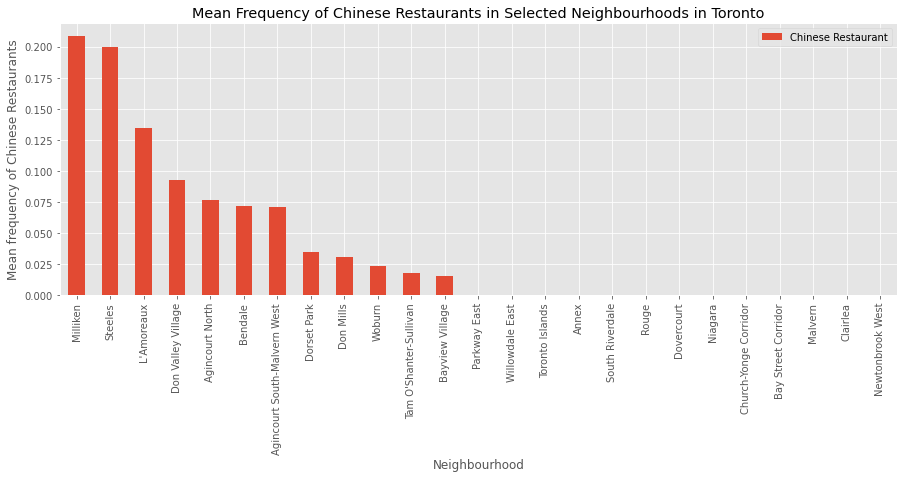

In [ ]:
# sort by descending order
toronto_grouped.sort_values(by='Chinese Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Chinese Restaurants in Selected Neighbourhoods in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Chinese Restaurants')

plt.show()

As inferred from the bar chart, Milliken and Steels are most densely populated with Chinese Restaurants; hence, they are not advisable for business operations to be taken place here.

**Plotting a bar graph to illustrate the distribution of Chinese population group in each neighbourhood**

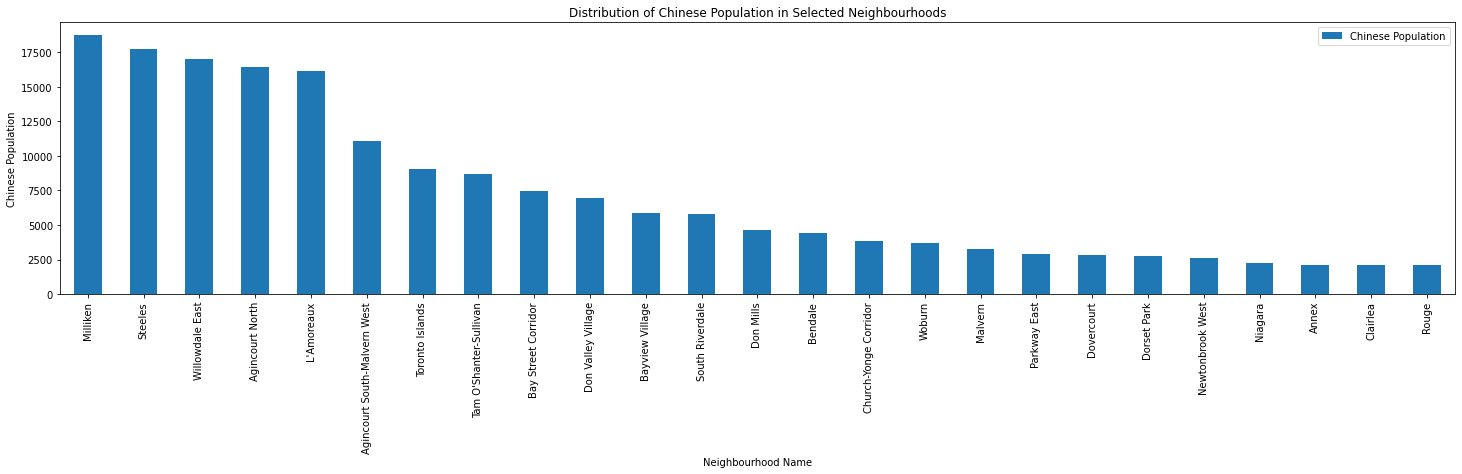

In [ ]:
df_ethnic = df_hoods[['Neighbourhood Name', 'Chinese Population']].set_index('Neighbourhood Name')

# sort by descending order
df_ethnic.sort_values(by='Chinese Population', ascending=False, inplace=True)

#plot bar graph
df_ethnic.plot(kind='bar', figsize=(25,5))
plt.title('Distribution of Chinese Population in Selected Neighbourhoods')
plt.xlabel('Neighbourhood Name')
plt.ylabel('Chinese Population')

plt.show()

As inferred from above, Milliken is the neighbourhood most populated with Chinese, which correlates with density of Chinese Restaurants.

**Plotting a bar graph to illustrate the distribution of income groups in each neighbourhood**

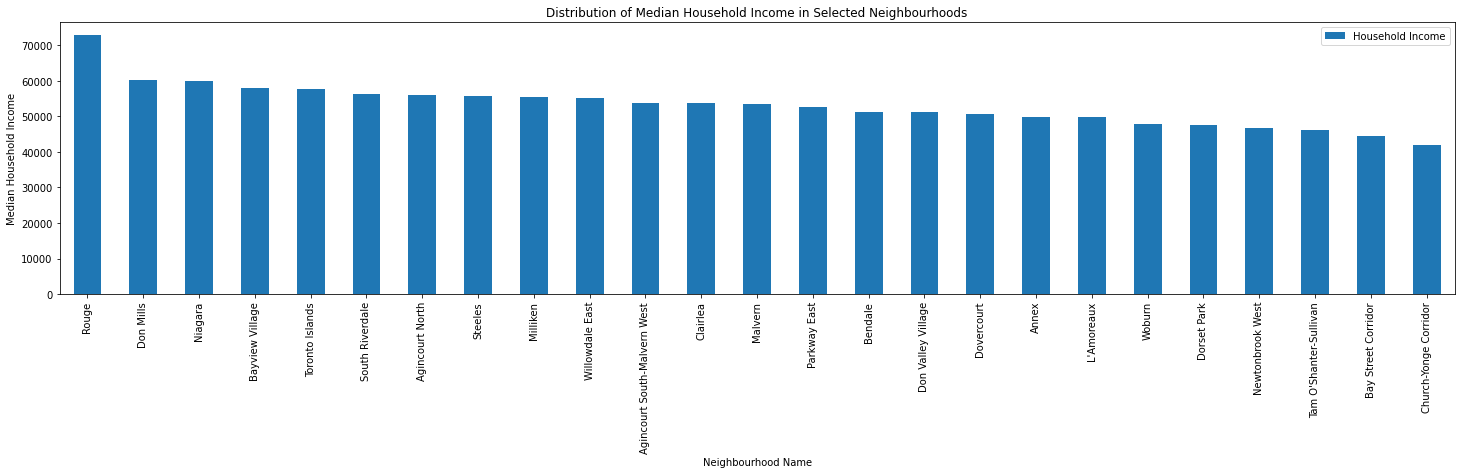

In [ ]:
df_income = df_hoods[['Neighbourhood Name', 'Household Income']].set_index('Neighbourhood Name')

# sort by descending order
df_income.sort_values(by='Household Income', ascending=False, inplace=True)

#plot bar graph
df_income.plot(kind='bar', figsize=(25,5))
plt.title('Distribution of Median Household Income in Selected Neighbourhoods')
plt.xlabel('Neighbourhood Name')
plt.ylabel('Median Household Income')

plt.show()

As inferred from above, Rouge is the neighbourhood with highest Household Income, but overall Household Income is more or less equal.

**Plotting a bar graph to illustrate the distribution of total population in each neighbourhood**

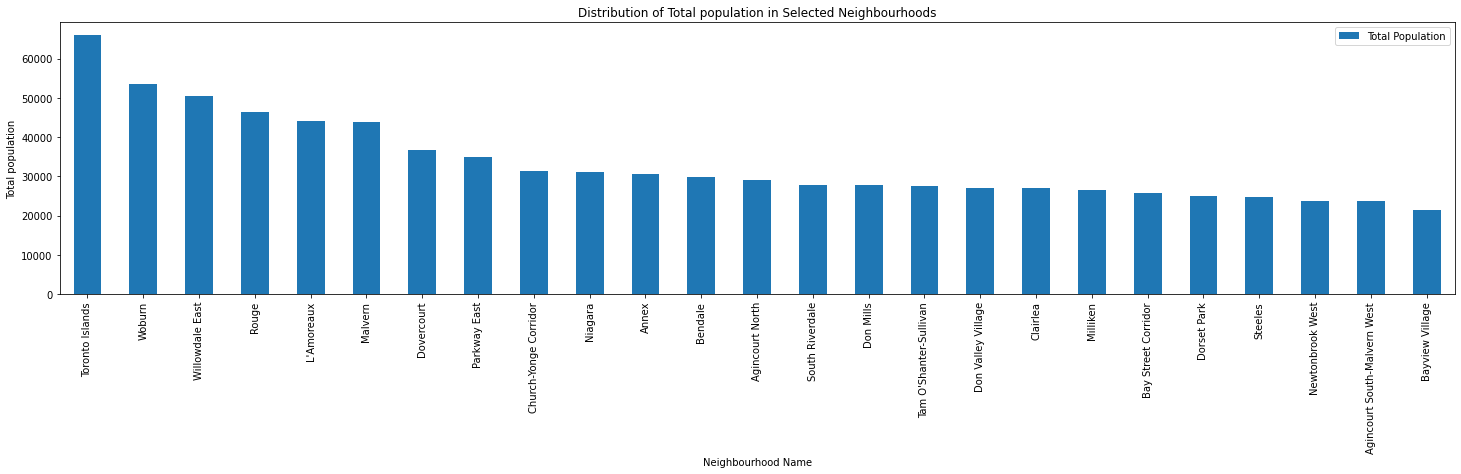

In [ ]:
df_popul = df_hoods[['Neighbourhood Name', 'Total Population']].set_index('Neighbourhood Name')

# sort by descending order
df_popul.sort_values(by='Total Population', ascending=False, inplace=True)

#plot bar graph
df_popul.plot(kind='bar', figsize=(25,5))
plt.title('Distribution of Total population in Selected Neighbourhoods')
plt.xlabel('Neighbourhood Name')
plt.ylabel('Total population')

plt.show()

There are Top 6 Neighborhoods by Total population. They were: ‘Toronto Islands’, ‘Woburn’, ‘Willowdale East’, ‘Rouge’, ‘L’Amoureaux’ and ‘Malvern’. Hence, they are advisable for business operations to be taken place there.

**Plotting a bar graph to illustrate the distribution of total crime rate in each neighbourhood**

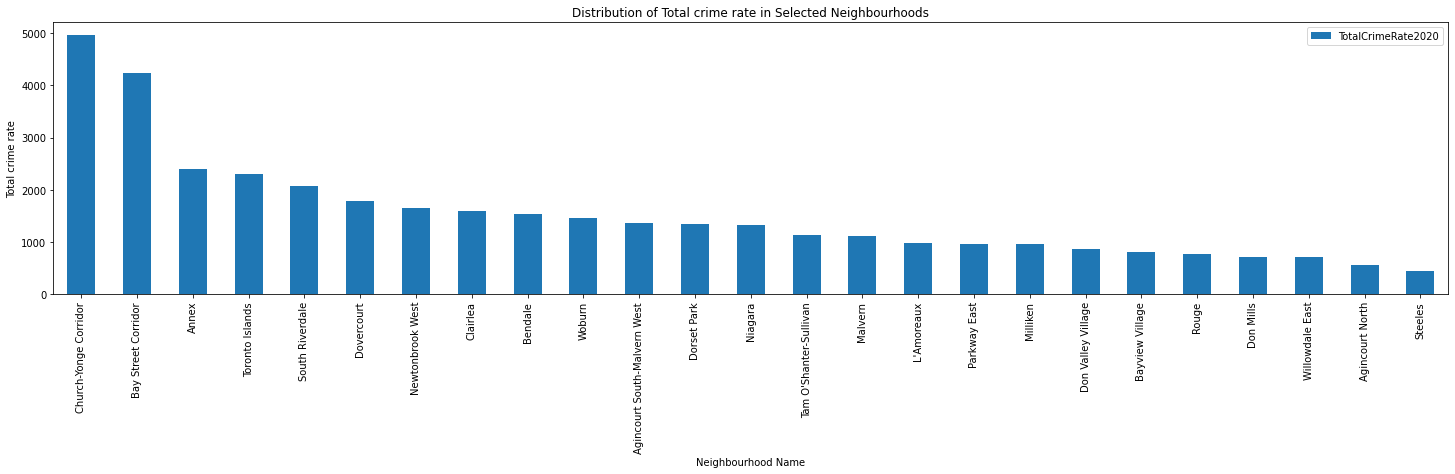

In [ ]:
df_crimerate = df_hoods[['Neighbourhood Name', 'TotalCrimeRate2020']].set_index('Neighbourhood Name')

# sort by descending order
df_crimerate.sort_values(by='TotalCrimeRate2020', ascending=False, inplace=True)

#plot bar graph
df_crimerate.plot(kind='bar', figsize=(25,5))
plt.title('Distribution of Total crime rate in Selected Neighbourhoods')
plt.xlabel('Neighbourhood Name')
plt.ylabel('Total crime rate')

plt.show()

There are Top 2 Neighborhoods with the highest Total crime rates. They were: ‘Church-Yonge Corridor’ and ‘Bay Street Corridor‘. Hence, they are not advisable for business operations to be taken place there.

### **4. Clustering of Neghbourhoods**

**Finalise a dataframe for clustering**

In [ ]:
# merge df_hoods with toronto_grouped
df_hoods_final = pd.merge(df_hoods, toronto_grouped, left_on='Neighbourhood Name', right_on='Neighbourhood')
print(df_hoods_final.shape)
df_hoods_final.head()

(25, 8)


Neighbourhood Name  Household Income  Total Population  Chinese Population  \
0    Newtonbrook West         46,815.00         23,831.00            2,650.00   
1           Don Mills         60,203.00         27,695.00            4,630.00   
2        Parkway East         52,550.00         34,805.00            2,875.00   
3  Don Valley Village         51,247.00         27,051.00            6,960.00   
4     Willowdale East         55,154.00         50,434.00           16,980.00   

   TotalCrimeRate2020  latitude  longitude  Chinese Restaurant  
0            1,654.22     43.80     -79.41                0.00  
1              718.27     43.78     -79.35                0.03  
2              956.69     43.76     -79.33                0.00  
3              860.37     43.79     -79.35                0.08  
4              712.11     43.76     -79.41                0.00

**Normalizing over the standard deviation**

Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

In [ ]:
from sklearn.preprocessing import StandardScaler
df_clustered = df_hoods_final.drop(columns=['Neighbourhood Name','latitude', 'longitude'])
X = df_clustered.to_numpy()
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)

In [ ]:
df_normalized = pd.DataFrame(Clus_dataSet)
df_normalized = df_normalized.rename({0: 'Household Income', 1: 'Total Population', 2: 'Chinese Population', 3: 'Crime Rate',  4: 'Chinese Restaurants Density'}, axis=1)
print(df_normalized.shape)
df_normalized.head()

(25, 5)


Household Income  Total Population  Chinese Population  Crime Rate  \
0             -1.03             -0.88               -0.83        0.13   
1              1.15             -0.53               -0.47       -0.77   
2             -0.10              0.13               -0.79       -0.54   
3             -0.31             -0.59               -0.05       -0.63   
4              0.33              1.56                1.77       -0.78   

   Chinese Restaurants Density  
0                        -0.62  
1                        -0.07  
2                        -0.62  
3                         0.78  
4                        -0.62

**Finding the optimal number of clusters, k**

So, how can we choose right value for K? The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =3, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.

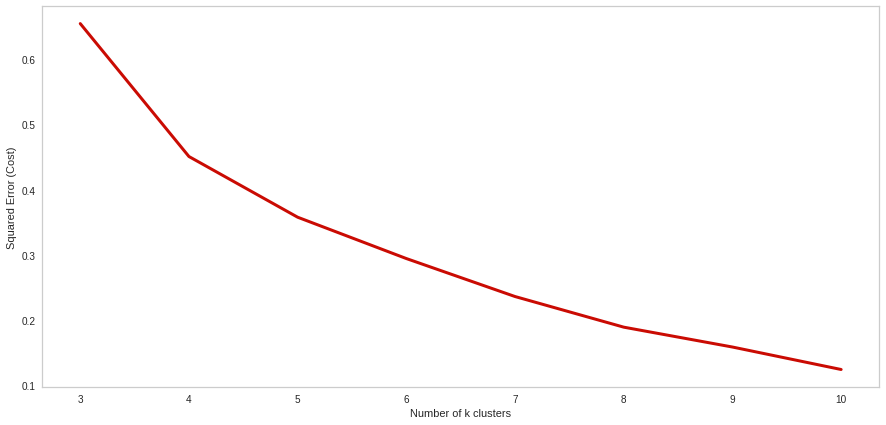

In [ ]:
from sklearn.cluster import KMeans

error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normalized)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(15,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f38ba7e1910>,
                 k=None, metric=None, model=None, timings=True)

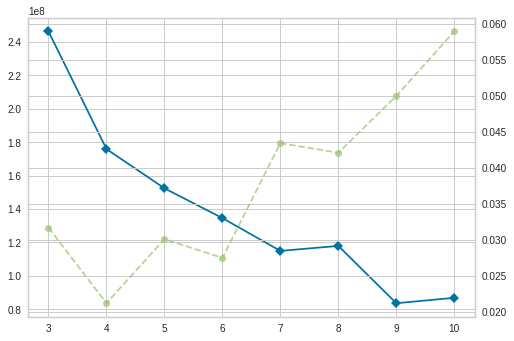

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11))

visualizer.fit(X)
visualizer

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 6 is the best value.

**Clustering the Toronto Neighborhood Using K-Means with K = 6**

In [ ]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 5, 0, 5, 2, 5, 0, 3, 3, 2], dtype=int32)

Create a new dataframe that includes the cluster

In [ ]:
df_hoods_final.insert(0, 'Cluster Label', kmeans.labels_)
df_hoods_final

Cluster Label            Neighbourhood Name  Household Income  \
0               0              Newtonbrook West         46,815.00   
1               5                     Don Mills         60,203.00   
2               0                  Parkway East         52,550.00   
3               5            Don Valley Village         51,247.00   
4               2               Willowdale East         55,154.00   
5               5               Bayview Village         58,028.00   
6               0               South Riverdale         56,192.00   
7               3         Church-Yonge Corridor         41,813.00   
8               3           Bay Street Corridor         44,614.00   
9               2               Toronto Islands         57,670.00   
10              0                       Niagara         59,929.00   
11              0                    Dovercourt         50,741.00   
12              0                         Annex         49,912.00   
13              1                       Steeles         55,755.00   
14              1                    L'Amoreaux         49,769.00   
15              0        Tam O'Shanter-Sullivan         46,095.00   
16              0                      Clairlea         53,716.00   
17              0                   Dorset Park         47,630.00   
18              0                       Bendale         51,254.00   
19              5  Agincourt South-Malvern West         53,886.00   
20              5               Agincourt North         55,893.00   
21              1                      Milliken         55,464.00   
22              4                         Rouge         72,784.00   
23              2                       Malvern         53,425.00   
24              2                        Woburn         47,908.00   

    Total Population  Chinese Population  TotalCrimeRate2020  latitude  \
0          23,831.00            2,650.00            1,654.22     43.80   
1          27,695.00            4,630.00              718.27     43.78   
2          34,805.00            2,875.00              956.69     43.76   
3          27,051.00            6,960.00              860.37     43.79   
4          50,434.00           16,980.00              712.11     43.76   
5          21,396.00            5,860.00              806.48     43.77   
6          27,876.00            5,800.00            2,077.75     43.66   
7          31,340.00            3,835.00            4,956.85     43.67   
8          25,797.00            7,435.00            4,239.10     43.67   
9          65,913.00            9,020.00            2,295.92     43.62   
10         31,180.00            2,260.00            1,318.18     43.64   
11         36,625.00            2,825.00            1,791.60     43.67   
12         30,526.00            2,145.00            2,393.31     43.67   
13         24,623.00           17,755.00              438.48     43.82   
14         43,993.00           16,165.00              987.24     43.80   
15         27,446.00            8,665.00            1,131.13     43.78   
16         26,984.00            2,120.00            1,593.75     43.71   
17         25,003.00            2,745.00            1,349.30     43.75   
18         29,960.00            4,400.00            1,531.89     43.75   
19         23,757.00           11,110.00            1,368.31     43.78   
20         29,113.00           16,460.00              566.13     43.81   
21         26,572.00           18,715.00              956.59     43.82   
22         46,496.00            2,100.00              773.77     43.80   
23         43,794.00            3,275.00            1,120.97     43.81   
24         53,485.00            3,715.00            1,457.61     43.76   

    longitude  Chinese Restaurant  
0      -79.41                0.00  
1      -79.35                0.03  
2      -79.33                0.00  
3      -79.35                0.08  
4      -79.41                0.00  
5      -79.38                0.02  
6      -79.34                0.0

**Create a map to visualise the clusters.**

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_hoods_final['latitude'], df_hoods_final['longitude'], df_hoods_final['Neighbourhood Name'], df_hoods_final['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

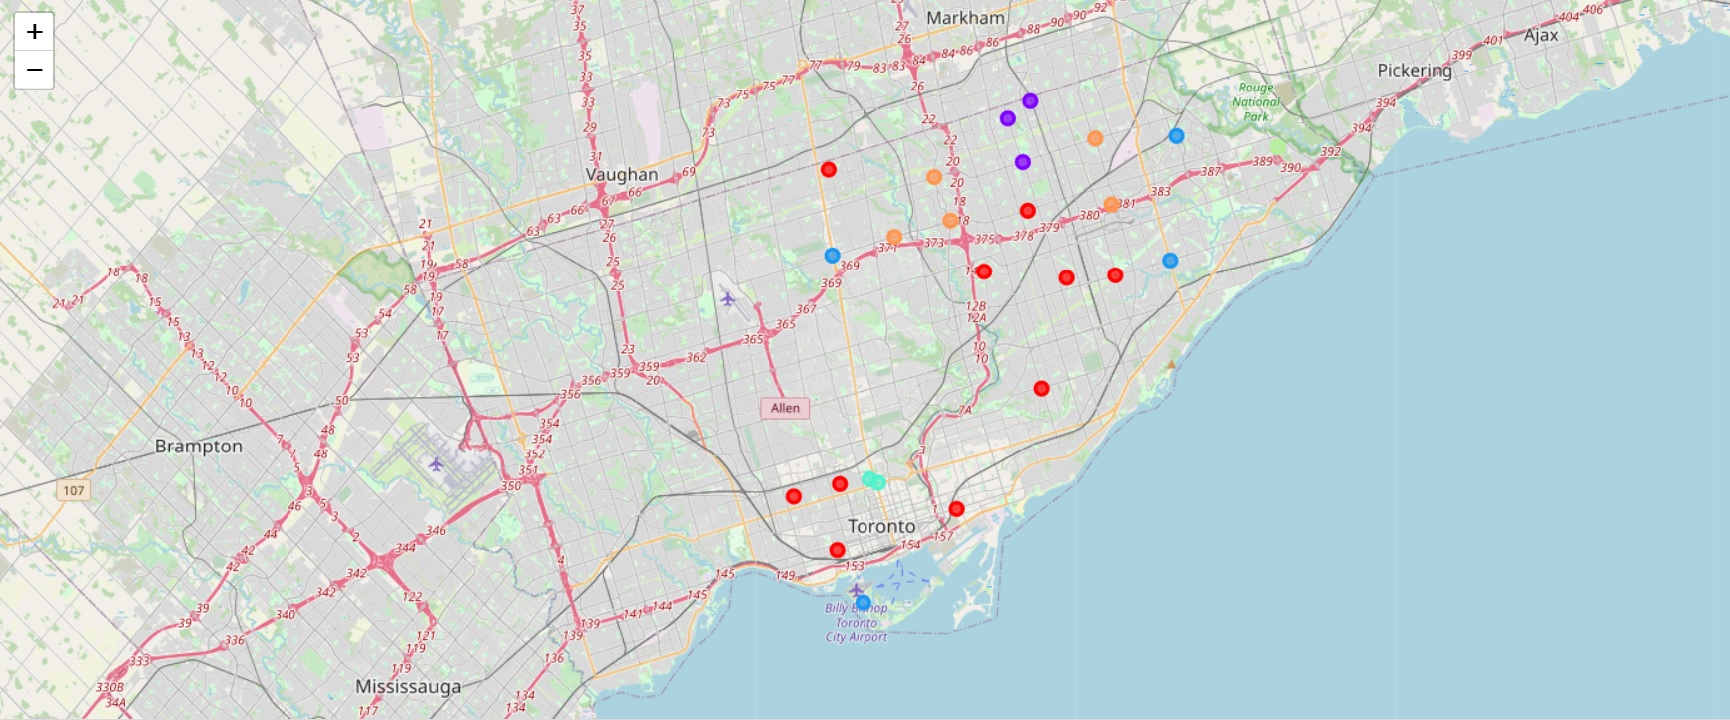

**Analyze the clusters.**

In [ ]:
df_hoods_final = df_hoods_final[['Cluster Label',	'Neighbourhood Name',	'Household Income',	'Total Population',	'Chinese Population',	'TotalCrimeRate2020',	'Chinese Restaurant']]
df_hoods_final.loc[df_hoods_final['Cluster Label'] == 0]

Cluster Label      Neighbourhood Name  Household Income  Total Population  \
0               0        Newtonbrook West         46,815.00         23,831.00   
2               0            Parkway East         52,550.00         34,805.00   
6               0         South Riverdale         56,192.00         27,876.00   
10              0                 Niagara         59,929.00         31,180.00   
11              0              Dovercourt         50,741.00         36,625.00   
12              0                   Annex         49,912.00         30,526.00   
15              0  Tam O'Shanter-Sullivan         46,095.00         27,446.00   
16              0                Clairlea         53,716.00         26,984.00   
17              0             Dorset Park         47,630.00         25,003.00   
18              0                 Bendale         51,254.00         29,960.00   

    Chinese Population  TotalCrimeRate2020  Chinese Restaurant  
0             2,650.00            1,654.22                0.00  
2             2,875.00              956.69                0.00  
6             5,800.00            2,077.75                0.00  
10            2,260.00            1,318.18                0.00  
11            2,825.00            1,791.60                0.00  
12            2,145.00            2,393.31                0.00  
15            8,665.00            1,131.13                0.02  
16            2,120.00            1,593.75                0.00  
17            2,745.00            1,349.30                0.03  
18            4,400.00            1,531.89                0.03

Cluster 0. It consists of neighborhoods with low total population and low competition rate. **Not recommended.**

In [ ]:
df_hoods_final.loc[df_hoods_final['Cluster Label'] == 1]

Cluster Label Neighbourhood Name  Household Income  Total Population  \
13              1            Steeles         55,755.00         24,623.00   
14              1         L'Amoreaux         49,769.00         43,993.00   
21              1           Milliken         55,464.00         26,572.00   

    Chinese Population  TotalCrimeRate2020  Chinese Restaurant  
13           17,755.00              438.48                0.17  
14           16,165.00              987.24                0.12  
21           18,715.00              956.59                0.21

•	Cluster 1. It consists of neighborhoods with high number of Chinese population and low crime rate. But competition rate is very high. **Not recommended.**

In [ ]:
df_hoods_final.loc[df_hoods_final['Cluster Label'] == 2]

Cluster Label Neighbourhood Name  Household Income  Total Population  \
4               2    Willowdale East         55,154.00         50,434.00   
9               2    Toronto Islands         57,670.00         65,913.00   
23              2            Malvern         53,425.00         43,794.00   
24              2             Woburn         47,908.00         53,485.00   

    Chinese Population  TotalCrimeRate2020  Chinese Restaurant  
4            16,980.00              712.11                0.00  
9             9,020.00            2,295.92                0.00  
23            3,275.00            1,120.97                0.00  
24            3,715.00            1,457.61                0.02

Cluster 2. It consists of neighborhoods with average number of Chinese population, low competition rate, and average Crime rate. **Recommended.**

In [ ]:
df_hoods_final.loc[df_hoods_final['Cluster Label'] == 3]

Cluster Label     Neighbourhood Name  Household Income  Total Population  \
7              3  Church-Yonge Corridor         41,813.00         31,340.00   
8              3    Bay Street Corridor         44,614.00         25,797.00   

   Chinese Population  TotalCrimeRate2020  Chinese Restaurant  
7            3,835.00            4,956.85                0.00  
8            7,435.00            4,239.10                0.00

Cluster 3. It consists of neighborhoods with comparatively low household income, zero competition rate, and with high Crime rate. **Not recommended.**

In [ ]:
df_hoods_final.loc[df_hoods_final['Cluster Label'] == 4]

Cluster Label Neighbourhood Name  Household Income  Total Population  \
22              4              Rouge         72,784.00         46,496.00   

    Chinese Population  TotalCrimeRate2020  Chinese Restaurant  
22            2,100.00              773.77                0.00

Cluster 4. It consists of neighborhoods with highest household income, average number of Chinese population, zero competition rate, and low Crime rate. **Recommended.**

In [ ]:
df_hoods_final.loc[df_hoods_final['Cluster Label'] == 5]

Cluster Label            Neighbourhood Name  Household Income  \
1               5                     Don Mills         60,203.00   
3               5            Don Valley Village         51,247.00   
5               5               Bayview Village         58,028.00   
19              5  Agincourt South-Malvern West         53,886.00   
20              5               Agincourt North         55,893.00   

    Total Population  Chinese Population  TotalCrimeRate2020  \
1          27,695.00            4,630.00              718.27   
3          27,051.00            6,960.00              860.37   
5          21,396.00            5,860.00              806.48   
19         23,757.00           11,110.00            1,368.31   
20         29,113.00           16,460.00              566.13   

    Chinese Restaurant  
1                 0.03  
3                 0.08  
5                 0.02  
19                0.07  
20                0.05

Cluster 5. It consists of neighborhoods with high competition rate and low total population. **Not recommended.**

### **5. Conclusion.**

1) 'Willowdale East'	from Cluster 2 is highly recommended neighbourhood to open Chinese restaurant due to high number of Chinese population, low crime rate and zero competition. In addition to that it has more than average total population and household income.

2) Second choice is 'Rouge' from Cluster 4 due to highest household income, low crime rate and zero competition. 